## ECE495 In-class Exercise 6: Spiking data
_Due 4/9 by start of class 0830_  
_4/9 class will be a Final Project workday - no work on this ICE!!_  

In this exercise, you will:
- Build an AER to create a spiking video
- Run said AER through Nengo neurons

The main concept of this exercise is:
- To understand the format of event-based data and how it is used

Why??
- To create extremely low power systems by collecting spiking data and processing on the spikes directly using spikes
***

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin (`nengo-loihi` installed)!**  
    
Then, import Nengo, NengoLoihi, and other supporting libraries into your program to get started:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

import nengo
import nengo_loihi

import pandas as pd

### Build your spiking data (i.e. your AER)

Your goal is to create an interesting spiking video with a *.csv file just like `ILAN City Frame Data.csv` OR with an event array (therefore bypassing the need for this line of code: `events = csv_to_event_array(csv_filename, start_time, end_time)`). _Most interesting video gets a prize_ - have fun with this!

**.csv file**

Take a look at the `ILAN City Frame Data.csv` file. You will see in that file that you have x- and y-coordinates at which an event took place, a polarity of said event, and the time of said event. I would recommend creating a video consisting of square images sized 100x100 pixels. If you would like for your video to have both positive and negative spiking events, use polarities of 1 and 0, respectively. 

**events_array**

The events array contains a list for every event consisting of the following values:   
- `y`: The vertical coordinate of the event.
- `x`: The horizontal coordinate of the event.
- `p`: The polarity of the event (0 for off, 1 for on).
- `v`: The event trigger (0 for camera events, 1 for external events). In our case, these will all be 0.
- `t`: The event timestamp _in microseconds_. 

You can see the format of this list - `[(y, x, p, v, t)]` for each event - within the `csv_to_event_array` function. You then fill the final `events_array` with `np.array(events_list, dtype=[('x', 'i4'), ('y', 'i4'), ('p', 'i4'), ('t', 'i4'), ('v', 'i4')])`. 

**Notes**

The next block of code is still built to read in a particular *.csv file. You will need to determine what to comment out / change to use the data you generate on your own.

In [12]:
# LtCol Jurado's Python wizardry
def csv_to_event_array(
    csv_filename: str, start_frame: int, end_frame: int
) -> np.ndarray:
    # ======= DVS camera - Physics dept ===========
    df = pd.read_csv(csv_filename, names=["x", "y", "p", "t"])

    df["v"] = np.zeros(len(df), dtype=int)
    sub_df = df[(start_frame <= df["t"]) & (df["t"] <= end_frame)]

    sub_df["t"] = sub_df["t"] - sub_df["t"].iloc[0]

    events_list = [(y, x, p, v, t) for x, y, p, t, v in sub_df.values]
    events_array = np.array(
        events_list,
        dtype=[("y", "i4"), ("x", "i4"), ("p", "i4"), ("v", "i4"), ("t", "i4")],
    )

    return events_array


# the csv file we will convert and the time range of our events

# ======= DVS camera - Physics dept ===========
csv_filename = "ICE6.csv"
start_time = 10000
end_time = 755000
# =============================================

# use the fancy function to turn this into the format Nengo likes
events = csv_to_event_array(csv_filename, start_time, end_time)
dvs_events = nengo_loihi.dvs.DVSEvents()
# this is really where the conversion happens
dvs_events.init_events(event_data=events)

# Save it as a *.events file!
events_file_name = "dvs-from-file-events.events"
dvs_events.write_file(events_file_name)
print("Wrote %r" % events_file_name)

Wrote 'dvs-from-file-events.events'


### View the data (NOT using neurons yet)

You will need to adjust some of the parameters in this block of code, such as image size and time steps. 

Note that once you've written an events file using `dvs_events` that you're good with, you can comment out the last block to save some time. 

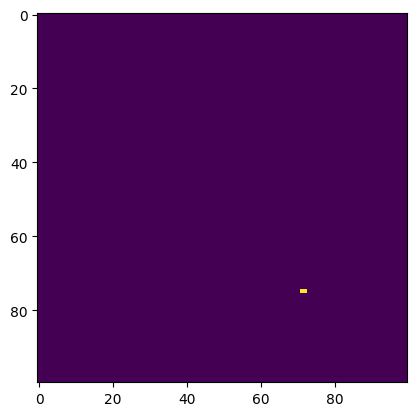

In [13]:
dvs_events = nengo_loihi.dvs.DVSEvents.from_file(events_file_name)

# ======= DVS camera - Physics dept ===========
img_height = 100  # 180
img_width = 100  # 240
t_length_us = end_time - start_time  # value is in microseconds
t_length_s = t_length_us * 1e-6  # convert prior value to seconds
dt_frame_us = (10 * 1e-3) * 1e6  # this value is also in microseconds
t_frames = dt_frame_us * np.arange(
    int(round(t_length_us / dt_frame_us))
)  # number of frames in video
# =============================================

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0_us = t_frame
    t1_us = t0_us + dt_frame_us
    t = dvs_events.events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = dvs_events.events[m]

    # Empty frame
    frame_img = np.zeros((img_height, img_width))

    for sub_event in events_m:
        # show "off" (0) events as -1 and "on" (1) events as +1
        event_sign = 2.0 * sub_event["p"] - 1
        frame_img[sub_event["y"], sub_event["x"]] = (
            frame_img[sub_event["y"], sub_event["x"]] + event_sign
        )

    img = plt.imshow(frame_img[:, ::-1], animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

### Build your model

You will likely need to adjust your `pool` size depending on the dimensions of your video and your `sim_time` based on the duration of your video.

You can read about `nengo_loihi.dvs.DVSFileChipProcess` [here](https://www.nengo.ai/nengo-loihi/api.html#dvs).
- `file_path`:The path of the file to read from. Can be a .aedat or .events file. Format of the file will be detected from the file extension.
- `pool`: Number of pixels to pool over in the vertical and horizontal directions, respectively. The larger the pool, the fewer neurons required.
- `channels_last`: Whether to make the channels (i.e. the polarity) the least-significant index (True) or the most-significant index (False).

To read about how to use enumerate in loop, look [here](https://www.geeksforgeeks.org/enumerate-in-python/). This will be useful for connecting arrays of neuron ensembles in your final project as it eliminates the need for indexing inside of a loop. You instead just call the second argument (in this example: `e`). 

`dvs_process.polarity` is the number of polarity values in the data. In this case we have 2: one for positive events, one for negative. The `::` is called a "stride" and can be used to skip through an array by a certain amount. In this case, we start at the $k^{th}$ value (0 or 1) and stride by 2. You can find some easier examples [here](https://scipython.com/book/chapter-2-the-core-python-language-i/examples/string-striding/).

Otherwise - this should all look familiar!

In [14]:
# ======= DVS camera - Physics dept ===========
pool = (2, 2)

model = nengo.Network(label="Spiking Data")
with model:
    dvs_process = nengo_loihi.dvs.DVSFileChipProcess(
        file_path=events_file_name,
        pool=pool,
        channels_last=True,
        dvs_height=img_height,
        dvs_width=img_width,
    )
    u = nengo.Node(dvs_process)

    ensembles = [
        nengo.Ensemble(dvs_process.height * dvs_process.width, 1)
        for _ in range(dvs_process.polarity)
    ]

    for k, e in enumerate(ensembles):
        u_channel = u[k :: dvs_process.polarity]
        nengo.Connection(u_channel, e.neurons, transform=1.0 / np.prod(pool))

    probes = [nengo.Probe(e.neurons) for e in ensembles]

with nengo.Simulator(model) as sim:
    sim.run(t_length_s)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### View the data (using Nengo neurons!)

This looks very much the same as viewing the data with regular Python - except now we are reading spikes from our probed neurons!

This section should not require any edits.

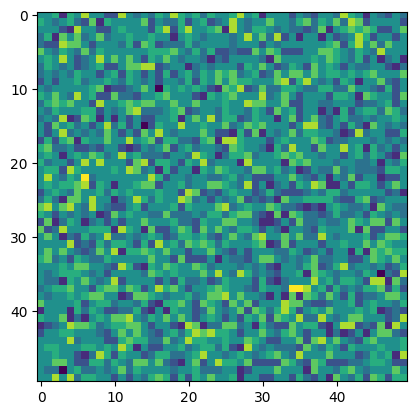

In [15]:
sim_t = sim.trange()
shape = (len(sim_t), dvs_process.height, dvs_process.width)
output_spikes_neg = sim.data[probes[0]].reshape(shape) * sim.dt
output_spikes_pos = sim.data[probes[1]].reshape(shape) * sim.dt

dt_frame = dt_frame_us * 1e-6  # this is in seconds
t_frames = dt_frame * np.arange(int(round(t_length_s / dt_frame)))

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0 = t_frame
    t1 = t_frame + dt_frame
    m = (sim_t >= t0) & (sim_t < t1)

    frame_img = np.zeros((dvs_process.height, dvs_process.width))
    frame_img -= output_spikes_neg[m].sum(axis=0)
    frame_img += output_spikes_pos[m].sum(axis=0)
    frame_img = frame_img / np.abs(frame_img).max()

    img = plt.imshow(frame_img[:, ::-1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

### Discussion - fill in an answer within the next markdown block

(1) Given the video you build, what is some data processing we could perform _within Nengo neurons_ on your data?

(2) Why would we want to do that?

1. The video I built was intended to create the letter 'A' using my AER. I kept the size of the "ball" small to represent drawing the character. The first form of data processing we could perform within Nengo neurons would be to set threshold for each nengo ensemble (ensemble=pixel) to indicate when the neuron at the location has fired. Therefore, a map of the path of the line could be deduced from this data. Additionally, we could utilize the opposite of inhibition to saturate the locations where the firing potential is met. This would allow for persistence and for the outputted image ('A') to stay on the screen. 
2. We would want to do this to ensure that the image does not get lost in the noise. This would allow for easier recognition of what we are seeing and for the ability to decipher what the input video is even if we don't make it ourselves. I believe this could be used in similar methods to determining character writing (one of the first examples we went over in class) based on Nengo neurons. 